In [34]:
import pandas as pd

In [35]:
training_df=pd.read_csv("../Datasets/training_df_raw.csv")
training_df.fillna(0,inplace=True)
training_df.drop(['date','time'],axis=1,inplace=True)
training_df.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,...,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,fire
0,10.4600,95.42882,9.7600,9.326071,0.0,0.0,0.0,0.0,0.0,1012.4,...,11.879999,10.7600,13.110001,14.0100,21.910000,0.275,0.318,0.195,0.026,1
1,10.4535,95.42859,9.7535,9.317741,0.0,0.0,0.0,0.0,0.0,1012.4,...,11.879999,10.7535,13.103500,14.0035,21.903500,0.275,0.318,0.195,0.026,1
2,10.4145,95.42721,9.7145,9.267784,0.0,0.0,0.0,0.0,0.0,1012.4,...,11.879999,10.7145,13.064501,13.9645,21.864500,0.275,0.318,0.195,0.026,1
3,9.2235,99.66392,9.1735,8.143780,0.0,0.0,0.0,0.0,0.0,1012.5,...,13.320000,10.4235,12.823500,13.7235,21.923500,0.273,0.324,0.201,0.020,1
4,9.2430,99.66399,9.1930,8.168585,0.0,0.0,0.0,0.0,0.0,1012.5,...,13.320000,10.4430,12.842999,13.7430,21.942999,0.273,0.324,0.201,0.020,1


In [36]:
training_df.shape

(113896, 31)

In [37]:
X=training_df.drop('fire',axis=1)
y=training_df['fire']

In [38]:
"""
Standard Scaling for the numerical variables cause every column is in different units - Centigrade, centimeter, millimeter etc
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def feature_transformation(encode_df):
    num_attributes=encode_df.columns.to_list()
    numeric_pipeline=Pipeline([
        ('std_scaler',StandardScaler())
    ])
    encoder_pipeline=ColumnTransformer([
        ("numeric_var",numeric_pipeline,num_attributes),
    ])
    df_encoded=encoder_pipeline.fit_transform(encode_df)
    return df_encoded,encoder_pipeline
X_transformed=feature_transformation(X)[0]

In [39]:
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import optuna
from sklearn.metrics import accuracy_score

### Feature Importance

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [41]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1,verbose=True)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.1s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=True)

In [43]:
"""
Built a random forest model and displayed the best features based on Gini Importance
"""
importances = rf.feature_importances_
feature_names=X.columns
feature_imp_df = pd.DataFrame({'Feature': X.columns.tolist(), 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
feature_imp_df

,Feature,Gini Importance
15,et0_fao_evapotranspiration,0.106557
22,soil_temperature_0_to_7cm,0.071965
23,soil_temperature_7_to_28cm,0.058234
1,relative_humidity_2m,0.046543
17,wind_speed_10m,0.046171
19,wind_direction_10m,0.044672
21,wind_gusts_10m,0.044190
18,wind_speed_100m,0.044107
10,surface_pressure,0.043244
20,wind_direction_100m,0.042781


In [44]:
"""
Analytically - The features with lower importance involve cloud cover, weather code, rain, snow.
Intuitively - You would expect rain, snow, weather code or cloud cover to have an effect on fire
"""
unimportant_features=feature_imp_df[feature_imp_df['Gini Importance']<(2/100)]['Feature'].tolist()

In [45]:
"""
This is an optional step because since we have only about 31 features, the only advantage of dropping features that are highly correlated is the increase in model building time
and not really the accuracy as seen below in the evaluation metrics. The AUC scores are pretty much the same
"""
high_correlated_features=['soil_temperature_7_to_28cm','wind_direction_10m','temperature_2m','soil_moisture_28_to_100cm',
                          'soil_moisture_7_to_28cm','soil_temperature_100_to_255cm','soil_temperature_28_to_100cm',
                          'soil_temperature_100_to_255cm','soil_moisture_100_to_255cm']

In [46]:
drop_features=unimportant_features+high_correlated_features
X.drop(drop_features,axis=1,inplace=True)
X.shape

(113896, 13)

### K Fold Cross Validation

In [59]:
X_transformed=feature_transformation(X)[0]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [63]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='accuracy')
print(f"Mean Accuracy = {np.mean(scores):.4f}")

Mean Accuracy = 0.8350


### Hyperparameter Tuning

In [50]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500, step=50)  
    max_depth = trial.suggest_int('max_depth', 3, 20) 
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20) 
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


print(f"Best hyperparameters: {study.best_params}")

print(f"Best validation accuracy: {study.best_value}")


[I 2024-11-06 16:42:02,998] A new study created in memory with name: no-name-db899c0e-f5d2-41ef-97db-b9ac2a86f5ba
[I 2024-11-06 16:42:42,651] Trial 0 finished with value: 0.7604477611940299 and parameters: {'n_estimators': 450, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.7604477611940299.
[I 2024-11-06 16:43:18,892] Trial 1 finished with value: 0.7194907813871817 and parameters: {'n_estimators': 450, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.7604477611940299.
[I 2024-11-06 16:44:00,795] Trial 2 finished with value: 0.7795434591747147 and parameters: {'n_estimators': 250, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 11, 'max_features': None, 'criterion': 'entropy'}. Best is trial 2 with value: 0.7795434591747147.
[I 2024-11-06 16:44:19,200] Trial 3 finished with value: 0.7054872695346

[I 2024-11-06 16:48:32,684] Trial 30 finished with value: 0.7543459174714662 and parameters: {'n_estimators': 450, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 23 with value: 0.8451273046532045.
[I 2024-11-06 16:48:46,533] Trial 31 finished with value: 0.844073748902546 and parameters: {'n_estimators': 400, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 23 with value: 0.8451273046532045.
[I 2024-11-06 16:49:01,718] Trial 32 finished with value: 0.8414837576821773 and parameters: {'n_estimators': 450, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 23 with value: 0.8451273046532045.
[I 2024-11-06 16:49:16,135] Trial 33 finished with value: 0.8464881474978051 and parameters: {'n_estimators': 400, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 

Best hyperparameters: {'n_estimators': 300, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy'}
Best validation accuracy: 0.8492098331870062


In [51]:
best_params=study.best_params

In [53]:
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                            min_samples_split=best_params['min_samples_split'],
                            min_samples_leaf=best_params['min_samples_leaf'],
                            max_features=best_params['max_features'],
                            max_depth=best_params['max_depth'],
                            criterion=best_params['criterion'],
                            n_jobs=-1)

### Training

In [54]:
X_transformed=feature_transformation(X)[0]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=23)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=19, min_samples_split=6,
                       n_estimators=300, n_jobs=-1)

In [55]:
y_pred=rf.predict(X_test)
y_scores = rf.predict_proba(X_test)[:, 1]

### Evaluation

In [56]:
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)
import matplotlib.pyplot as plt
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.84     11452
           1       0.81      0.91      0.85     11328

    accuracy                           0.85     22780
   macro avg       0.85      0.85      0.84     22780
weighted avg       0.85      0.85      0.84     22780



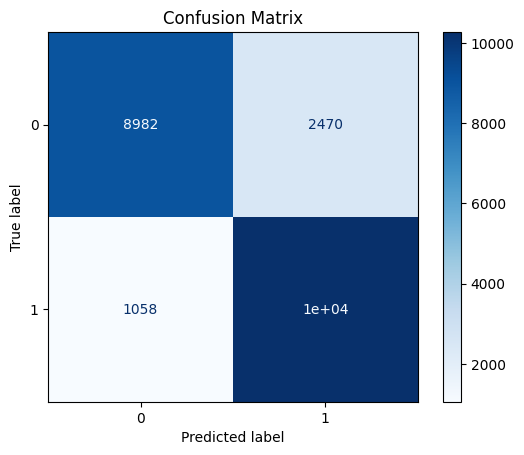

In [57]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

AUC-ROC Score: 0.9222339850155699


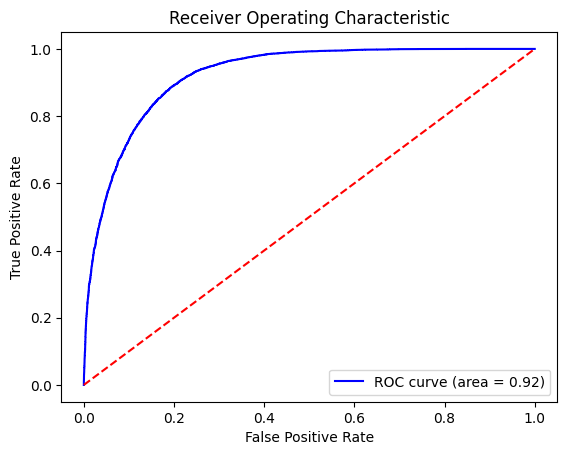

In [58]:
auc_score = roc_auc_score(y_test, y_scores)
print("AUC-ROC Score:", auc_score)


fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()